<a href="https://colab.research.google.com/github/Amir-D-Shadow/Google-Colab/blob/main/tensorflow_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

In [2]:
class CBL(tf.keras.Model):

   def __init__(self,filters=32,kernel_size=3,strides=2,padding='valid',**kwargs):

      #initialization
      super(CBL,self).__init__(**kwargs)

      #define layers
      self.conv2D_x = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding)

      self.BN_x = tf.keras.layers.BatchNormalization(axis=3)

      self.output_leaky_relu = tf.keras.layers.LeakyReLU()
      

   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #convolution layer
      conv2D_x = self.conv2D_x(inputs)

      #Batch Normalization layer
      BN_x = self.BN_x(conv2D_x)

      #activate by Leaky relu
      output_leaky_relu = self.output_leaky_relu(BN_x)

      return output_leaky_relu

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
      
      return tf.keras.Model(inputs=x,outputs=self.call(x))

In [3]:
#activation Mish
def Mish(x):

   softplus = tf.math.softplus(x)
   tanh_s = tf.math.tanh(softplus)

   return (x * tanh_s)


#CBM Module
class CBM(tf.keras.Model):

   def __init__(self,filters=32,kernel_size=3,strides=2,padding="valid",**kwargs):

      #initialization
      super(CBM,self).__init__(**kwargs)

      #define layers
      self.conv2D_x = tf.keras.layers.Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding=padding)

      self.BN_x = tf.keras.layers.BatchNormalization(axis=3)

      self.output_Mish = tf.keras.layers.Lambda(Mish,name="Mish")

      

   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """

      #Convolution 2D layer
      conv2D_x = self.conv2D_x(inputs)

      #Batch Normalization layer
      BN_x = self.BN_x(conv2D_x)

      #activate by Mish
      output_Mish = self.output_Mish(BN_x)

      return output_Mish

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
      
      return tf.keras.Model(inputs=x,outputs=self.call(x))

In [4]:
class SPP(tf.keras.Model):

   def __init__(self,**kwargs):

      #initialization
      super(SPP,self).__init__(**kwargs)

      #define layers
      self.maxpool_5x5 = tf.keras.layers.MaxPooling2D(pool_size=5,strides=1,padding="same")

      self.maxpool_9x9 = tf.keras.layers.MaxPooling2D(pool_size=9,strides=1,padding="same")

      self.maxpool_13x13 = tf.keras.layers.MaxPooling2D(pool_size=13,strides=1,padding="same")


   def call(self,inputs):

      """
      input -- tensorflow layer with shape (m,n_H,n_W,n_C)
      """
      
      #5x5
      maxpool_5x5 = self.maxpool_5x5(inputs)

      #9x9
      maxpool_9x9 = self.maxpool_9x9(inputs)

      #13x13
      maxpool_13x13 = self.maxpool_13x13(inputs)

      #concatenate
      output_concat = tf.keras.layers.concatenate(inputs=[maxpool_5x5,maxpool_9x9,maxpool_13x13,inputs],axis=3)

      return output_concat

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
      
      return tf.keras.Model(inputs=x,outputs=self.call(x))

In [5]:
class res_unit(tf.keras.Model):

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
      
      return tf.keras.Model(inputs=x,outputs=self.call(x))

   def __init__(self,block_info,**kwargs):

      """
      block_info -- dictionary containing blocks' hyperparameters (filters,kernel_size,strides,padding)

      Module Graph:

      ------ CBM_1 ------ CBM_2 ------ Add
         |                              |
         |                              |
         |                              |
         --------------------------------

      
      """

      #initialization
      super(res_unit,self).__init__(**kwargs)
      
      #1st CBM block
      filters,kernel_size,strides,padding = block_info["CBM_1"]
      
      self.CBM_1 = CBM(filters,kernel_size,strides,padding)

      #2nd CBM block
      filters,kernel_size,strides,padding = block_info["CBM_2"]

      self.CBM_2 = CBM(filters,kernel_size,strides,padding)

      #Add Layer
      self.Add_layer = tf.keras.layers.Add()


   def call(self,inputs):

      x = inputs

      #1st CBM block
      CBM_1 = self.CBM_1(inputs)

      #2nd CBM block
      CBM_2 = self.CBM_2(CBM_1)

      #Add Layer
      output_shortcut = self.Add_layer([CBM_2,x])

      return output_shortcut


In [6]:
class CSPX(tf.keras.Model):

   def __init__(self,CSPX_info,**kwargs):

      """
      CSPX_info -- dictionary containing information: num_of_res_unit , res_unit block info , CBM block info , CBL_info

                     - hpara: (filters,kernel_size,strides,padding)

                     
      Module Graph:
      
      ------ CBL_1 ------ CBL_2 ------ res_unit * X ------ CBL_3 -----
                     |                                               |
                     |                                               |______
                     |                                                ______  Concat --- BN --- leaky relu --- CBM_1 
                     |                                               |
                     |                                               |
                     -------------------------------- CBL_4 ----------
      """

      #initialization
      super(CSPX,self).__init__(**kwargs)

      #extract num_of_res_unit
      self.num_of_res_unit = CSPX_info["num_of_res_unit"]

      #define layers

      #res_unit
      self.res_unit_branch = {}

      #Important: When defining the CSPX layer, remember to define res unit info (dictionary key) in the form of res_unit_i : i start from 1
      for i in range(1,self.num_of_res_unit+1):

         #Extract res_unit_i info
         res_unit_info = CSPX_info[f"res_unit_{i}"]

         #define resunit layer
         self.res_unit_branch[f"res_unit_{i}"] = res_unit(res_unit_info)
         

      #CBL_1
      filters,kernel_size,strides,padding = CSPX_info["CBL_1"]
      
      self.CBL_1 = CBL(filters,kernel_size,strides,padding)

      #CBL_2
      filters,kernel_size,strides,padding = CSPX_info["CBL_2"]
      
      self.CBL_2 = CBL(filters,kernel_size,strides,padding)

      #CBL_3
      filters,kernel_size,strides,padding = CSPX_info["CBL_3"]
      
      self.CBL_3 = CBL(filters,kernel_size,strides,padding)

      #CBL_4
      filters,kernel_size,strides,padding = CSPX_info["CBL_4"]
      
      self.CBL_4 = CBL(filters,kernel_size,strides,padding)

      #BN
      self.BN_x = tf.keras.layers.BatchNormalization(axis=3)

      #leaky relu
      self.leaky_relu_x = tf.keras.layers.LeakyReLU()

      #CBM_1
      filters,kernel_size,strides,padding = CSPX_info["CBM_1"]

      self.CBM_1 = CBM(filters,kernel_size,strides,padding)
      

   def call(self,inputs):

      x = inputs

      #CBL_1
      CBL_1 = self.CBL_1(x)

      #CBL_2
      CBL_2 = self.CBL_2(CBL_1)

      #res_unit block
      res_unit_block = CBL_2
      
      for i in range(1,self.num_of_res_unit+1):

         res_unit_block =  (self.res_unit_branch[f"res_unit_{i}"])(res_unit_block) 

      #CBL3
      CBL_3 = self.CBL_3(res_unit_block)
      
      #CBL_4
      CBL_4 = self.CBL_4(CBL_1)

      #Concat
      mid_concat = tf.keras.layers.concatenate(inputs=[CBL_3,CBL_4],axis=3)

      #Batch Normalization
      BN_x = self.BN_x(mid_concat)

      #leaky_relu_x
      leaky_relu_x = self.leaky_relu_x(BN_x)

      #output_CBM
      output_CBM = self.CBM_1(leaky_relu_x)

      return output_CBM

   def graph_model(self,dim):

      x = tf.keras.layers.Input(shape=dim)
        
      return tf.keras.Model(inputs=x,outputs=self.call(x))


In [7]:
CSPX_info = {}

#num_of_res_unit
CSPX_info["num_of_res_unit"] = 4

#res_unit_info

res_unit_1 = {}
res_unit_1["CBM_1"] = (512,1,1,"same")
res_unit_1["CBM_2"] = (512,3,1,"same")
CSPX_info["res_unit_1"] = res_unit_1

res_unit_2 = {}
res_unit_2["CBM_1"] = (512,1,1,"same")
res_unit_2["CBM_2"] = (512,3,1,"same")
CSPX_info["res_unit_2"] = res_unit_2

res_unit_3 = {}
res_unit_3["CBM_1"] = (512,1,1,"same")
res_unit_3["CBM_2"] = (512,3,1,"same")
CSPX_info["res_unit_3"] = res_unit_3

res_unit_4 = {}
res_unit_4["CBM_1"] = (512,1,1,"same")
res_unit_4["CBM_2"] = (512,3,1,"same")
CSPX_info["res_unit_4"] = res_unit_4

#CBL_1
CSPX_info["CBL_1"] = (1024,3,2,"valid")

#CBL_2
CSPX_info["CBL_2"] = (512,1,1,"same")

#CBL_3
CSPX_info["CBL_3"] = (512,1,1,"same")

#CBL_4
CSPX_info["CBL_4"] = (512,1,1,"same")

#CBM_1
CSPX_info["CBM_1"] = (1024,1,1,"same")

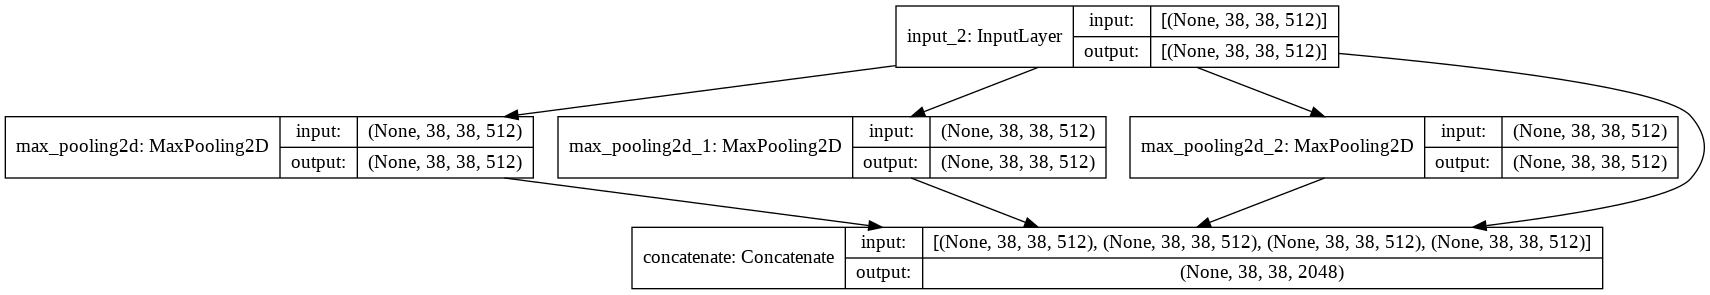

In [8]:
#SPP
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = SPP()
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

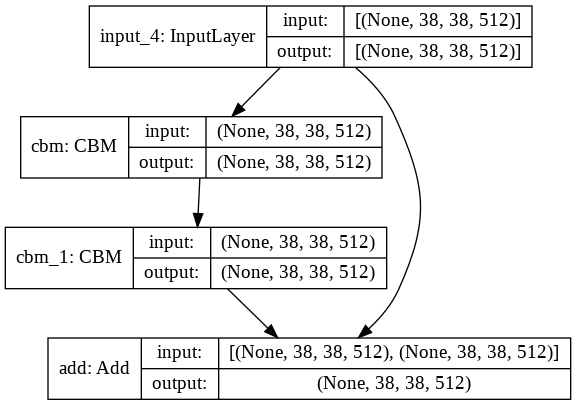

In [9]:
#res unit
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = res_unit(res_unit_1)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

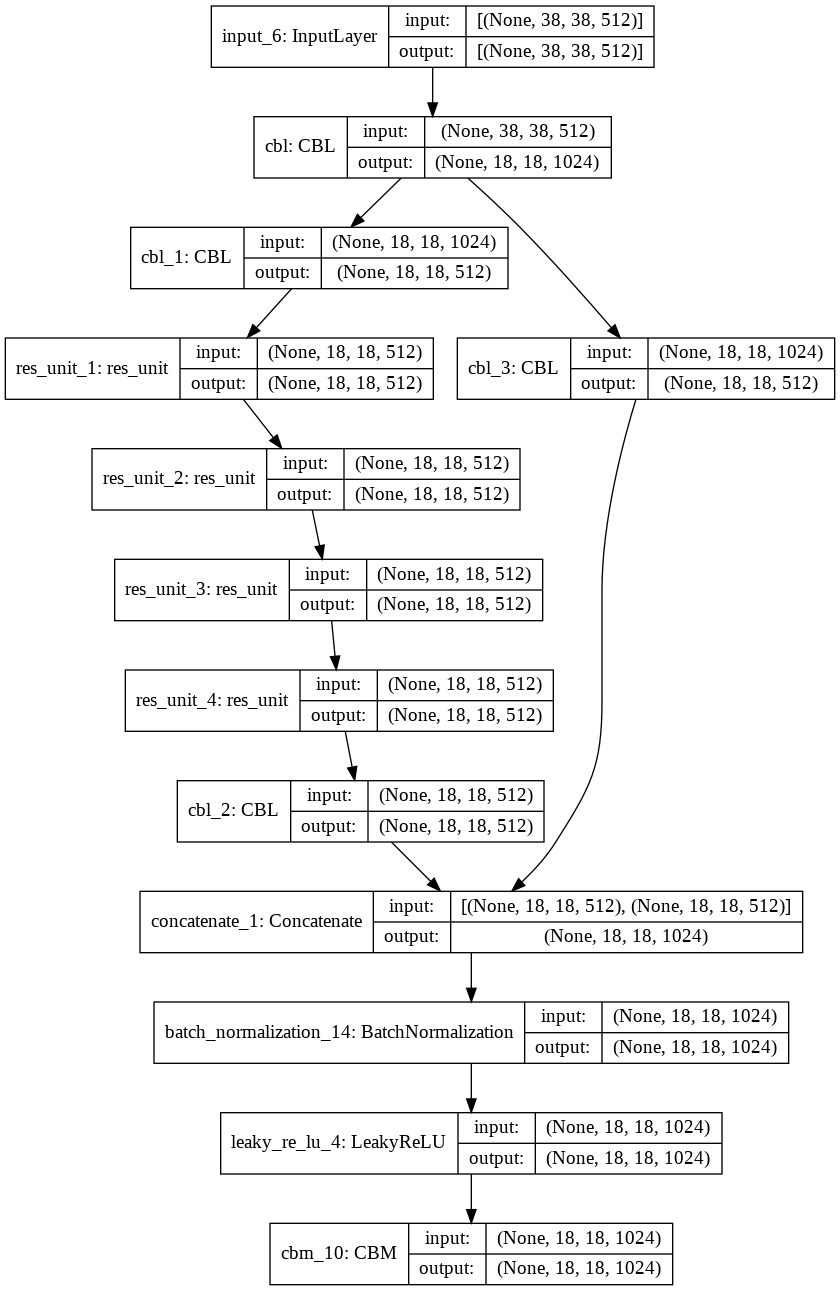

In [10]:
#res unit
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))

y = CSPX(CSPX_info)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

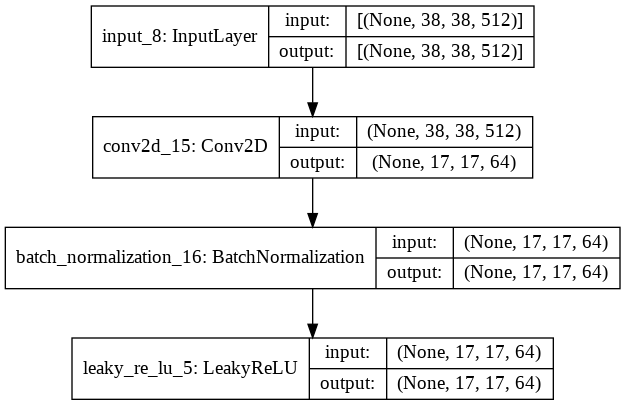

In [11]:
#CBL
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))
filters,kernel_size,strides,padding = 64,6,2,"valid"

y = CBL(filters,kernel_size,strides,padding)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)

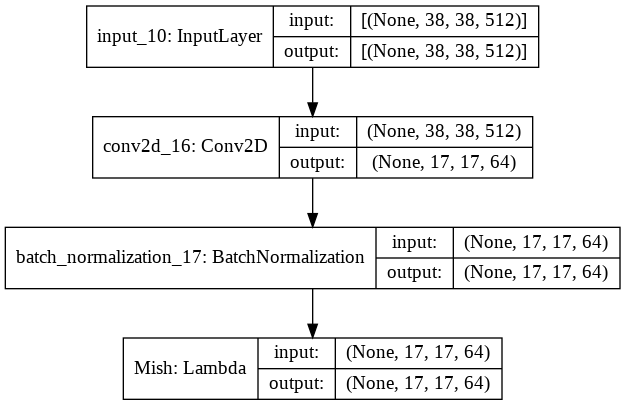

In [12]:
#CBM
initializer = tf.random_normal_initializer()
k = tf.Variable(initial_value=initializer(shape=(10,38,38,512),dtype="float32"))
in_x = tf.keras.layers.Input(shape=tuple(k.get_shape().as_list()[1:]))
filters,kernel_size,strides,padding = 64,6,2,"valid"

y = CBM(filters,kernel_size,strides,padding)
model = y.graph_model(tuple(in_x.get_shape().as_list()[1:]))
plot_model(model,show_shapes=True, show_layer_names=True)